In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../src')
import utils.visualization as vis
import utils.preprocession as prep
from utils.metrics import NearestCandidates, overlap
from models.IDEAL import IDEAL

## Config

In [2]:
save_figures = True
folder_name = 'Smartvote'
data_name = 'Binary'
p = 90

## Data

In [3]:
def savefig(fig, name='TestFigure'): 
    if save_figures:
        fig.savefig(f"../../reports/ecpr-conference/figures/{folder_name}_{data_name}_{name}.pdf") 

folder_path = f"../../data/{folder_name}"
data_path = f"../../data/{folder_name}/{data_name}"

test_users = pd.read_csv(f'{folder_path}/test_candidates.csv', index_col=0)
train_users = pd.read_csv(f'{folder_path}/train_candidates.csv', index_col=0)

train_reactions = pd.read_csv(f'{data_path}/train_reactions_0.csv', index_col=0)
start_reactions = pd.read_csv(f'{data_path}/test_reactions_{p}.csv', index_col=0)
test_reactions = pd.read_csv(f'{data_path}/test_reactions_0.csv', index_col=0)

statements = pd.read_csv(f"../../data/{folder_name}/statements.csv", index_col=0)

K = test_reactions.shape[1]
start_reactions.head()


,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
9,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


## Model

In [4]:
method_path = f"../../embeddings/IDEAL/{folder_name}"
start_embedding = pd.read_csv(f'{method_path}/test_embedding_0_{p}.csv', index_col=0)
test_embedding = pd.read_csv(f'{method_path}/test_embedding_0_0.csv', index_col=0)
train_embedding = pd.read_csv(f'{method_path}/train_embedding_0.csv', index_col=0)

ideal = IDEAL(pd.read_csv(f'{method_path}/betabar_0.csv', index_col=0), 
              pd.read_csv(f'{method_path}/xbar_0.csv', index_col=0),
              index=train_reactions.index, columns=train_reactions.columns)

d, r = 2, 200
ideal.make_probabilistic(d=d, r=r)

## Metric

In [10]:
k = 32

candidates = NearestCandidates(train_embedding, k=k)
latent_neighbors = test_embedding.apply(candidates.recommend, axis=1)

candidates = NearestCandidates(train_reactions, k=k)
true_neighbors = test_reactions.apply(candidates.recommend, axis=1)

rapid = statements.loc[statements['rapid']].index.astype(str)
fast_reactions = pd.DataFrame(index=test_reactions.index, columns=train_reactions.columns, dtype=np.float64)
rand_neighbors = fast_reactions.apply(candidates.recommend, axis=1)

fast_reactions.loc[:,rapid] = test_reactions.loc[:,rapid]
fast_predictions =  fast_reactions.apply(ideal.predict_user, axis=1)
pred_neighbors   = fast_predictions.apply(candidates.recommend, axis=1)

fast_neighbors = test_reactions.loc[:,rapid].apply(candidates.recommend, axis=1)

res = pd.concat([true_neighbors,fast_neighbors,pred_neighbors, rand_neighbors, latent_neighbors], axis=1)
res.columns = ['True','Fast','Pred', 'Rand', 'Late']
res['Fast-Res'] = res.apply(lambda row: overlap(row['True'], row['Fast']), axis=1)
res['Pred-Res'] = res.apply(lambda row: overlap(row['True'], row['Pred']), axis=1)
res['Rand-Res'] = res.apply(lambda row: overlap(row['True'], row['Rand']), axis=1)
res['Late-Res'] = res.apply(lambda row: overlap(row['True'], row['Late']), axis=1)
res.loc[:,['Pred-Res','Fast-Res', 'Rand-Res', 'Late-Res']].mean()


Pred-Res    0.474461
Fast-Res    0.405603
Rand-Res    0.020366
Late-Res    0.165948
dtype: float64

## Method

In [8]:
n = 459
user = start_reactions.loc[n]
# user = test_reactions.loc[n]
# user.loc[[str(i) for i in range(12, 15)]] = np.NaN

### SET user=... for debuggging
given_answers = user.loc[~user.isna()]
open_answers = user.loc[user.isna()]

P_Yn1_X = ideal.likelihood_X.loc[:,open_answers.index].values ## (40000, 45)
P_Yn0_X = 1 - P_Yn1_X
P_X_Yi = ideal.posterior_X(given_answers) ## (40000,1)

P_XYn0_Yi = P_Yn0_X * P_X_Yi ## (40000, 45)
P_XYn1_Yi = P_Yn1_X * P_X_Yi ## (40000, 45)
assert np.allclose((P_XYn0_Yi+P_XYn1_Yi).sum(axis=0), 1, rtol=1e-5), "X Posteriors don't sum to 1"

P_Yn1_Yi  = P_XYn1_Yi.sum(axis=0) ## (45,)
# P_Yn0_Yi  = P_XYn0_Yi.sum(axis=0) ## (45,)
# assert np.all(np.isclose(P_Yn1_Yi+P_Yn0_Yi, 1, rtol=1e-5)), "Y Marginals don't sum to 1"

P_X_Yin1 = np.ones_like(P_XYn1_Yi, dtype=np.float64)/P_XYn1_Yi.shape[0]  ## (40000, 45) with uniform distribution
mask = np.where(P_XYn1_Yi.sum(axis=0)!=0)
P_X_Yin1[:,mask]=P_XYn1_Yi[:,mask]/P_XYn1_Yi[:,mask].sum(axis=0)

P_X_Yin0 = np.ones_like(P_XYn0_Yi, dtype=np.float64)/P_XYn0_Yi.shape[0]  ## (40000, 45) with uniform distribution
mask = np.where(P_XYn0_Yi.sum(axis=0)!=0)
P_X_Yin0[:,mask]=P_XYn0_Yi[:,mask]/P_XYn0_Yi[:,mask].sum(axis=0)
# P_X_Yin1  = P_XYn1_Yi / P_Yn1_Yi ## (40000, 45)
# P_X_Yin0  = P_XYn0_Yi / P_Yn0_Yi ## (40000, 45)
assert np.all(np.isclose(P_X_Yin1.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=1 don't sum to 1"
assert np.all(np.isclose(P_X_Yin0.sum(axis=0), 1, rtol=1e-5)), "X Posterior for Yn=0 don't sum to 1"

P_Yn1_Yin1 = np.tensordot(P_Yn1_X, P_X_Yin1, axes=[0,0]) ## (45,45)
P_Yn1_Yin0 = np.tensordot(P_Yn1_X, P_X_Yin0, axes=[0,0]) ## (45,45)
# P_Yn0_Yin1 = np.tensordot(P_Yn0_X, P_X_Yin1, axes=[0,0]) ## (45,45)
# P_Yn0_Yin0 = np.tensordot(P_Yn0_X, P_X_Yin0, axes=[0,0]) ## (45,45)
# assert np.allclose(P_Yn1_Yin1 + P_Yn0_Yin1, 1, rtol=1e-5)
# assert np.allclose(P_Yn1_Yin0 + P_Yn0_Yin0, 1, rtol=1e-5)
np.fill_diagonal(P_Yn1_Yin1, 1)
np.fill_diagonal(P_Yn1_Yin0, 0)

In [17]:
%%time 
factor = 20

posterior_knn_losses = []
for i in range(5):
    ### FIRST compute PRIOR KNN Variance
    n_samples = user.isna().sum()*factor
    predictions = ideal.predict_user(user)
    indices = candidates.recommend(predictions)
    prior = candidates.probabilistic(pd.DataFrame(predictions).T, n_samples=n_samples)
    print(np.allclose(indices, train_reactions.iloc[prior.iloc[0,0]].index), prior.iloc[0,1], n_samples)

    ### Now for the POSTERIOR KNN variance (given Yn=1)
    pseudo_answers_Y1 = pd.DataFrame([user]*len(open_answers.index))
    pseudo_answers_Y1.index = open_answers.index
    pseudo_answers_Y1.loc[:,open_answers.index] = P_Yn1_Yin1.T
    result_Y1 = candidates.probabilistic(pseudo_answers_Y1, n_samples=n_samples)

    ### Now for the POSTERIOR KNN variance (given Yn=0)
    pseudo_answers_Y0 = pd.DataFrame([user]*len(open_answers.index))
    pseudo_answers_Y0.index = open_answers.index
    pseudo_answers_Y0.loc[:,open_answers.index] = P_Yn1_Yin0.T
    result_Y0 = candidates.probabilistic(pseudo_answers_Y0, n_samples=n_samples)

    ### Now compute the expected loss of POSTERIOR KNN 
    posterior_knn = P_Yn1_Yi*result_Y1.loc[open_answers.index, 'variance'] + (1-P_Yn1_Yi)*result_Y0.loc[open_answers.index, 'variance']
    posterior_knn_losses.append((prior.iloc[0,1] - posterior_knn).values)

True 0.641015625 1360
True 0.6420726102941177 1360
True 0.6393152573529411 1360
True 0.6423713235294117 1360
True 0.6383042279411765 1360
CPU times: user 49.4 s, sys: 16.6 s, total: 1min 5s
Wall time: 45.3 s


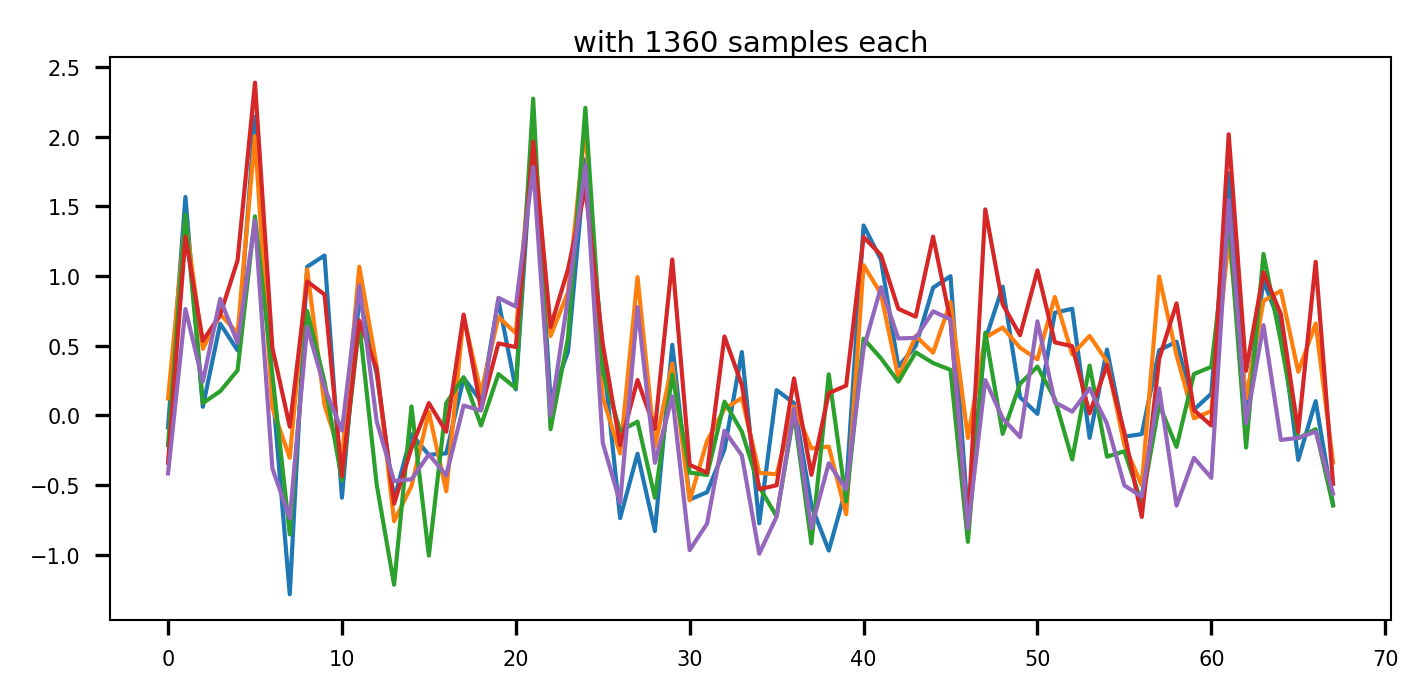

In [19]:
for res in posterior_knn_losses:
    plt.plot(100*res)
    plt.title(f'with {n_samples} samples each')

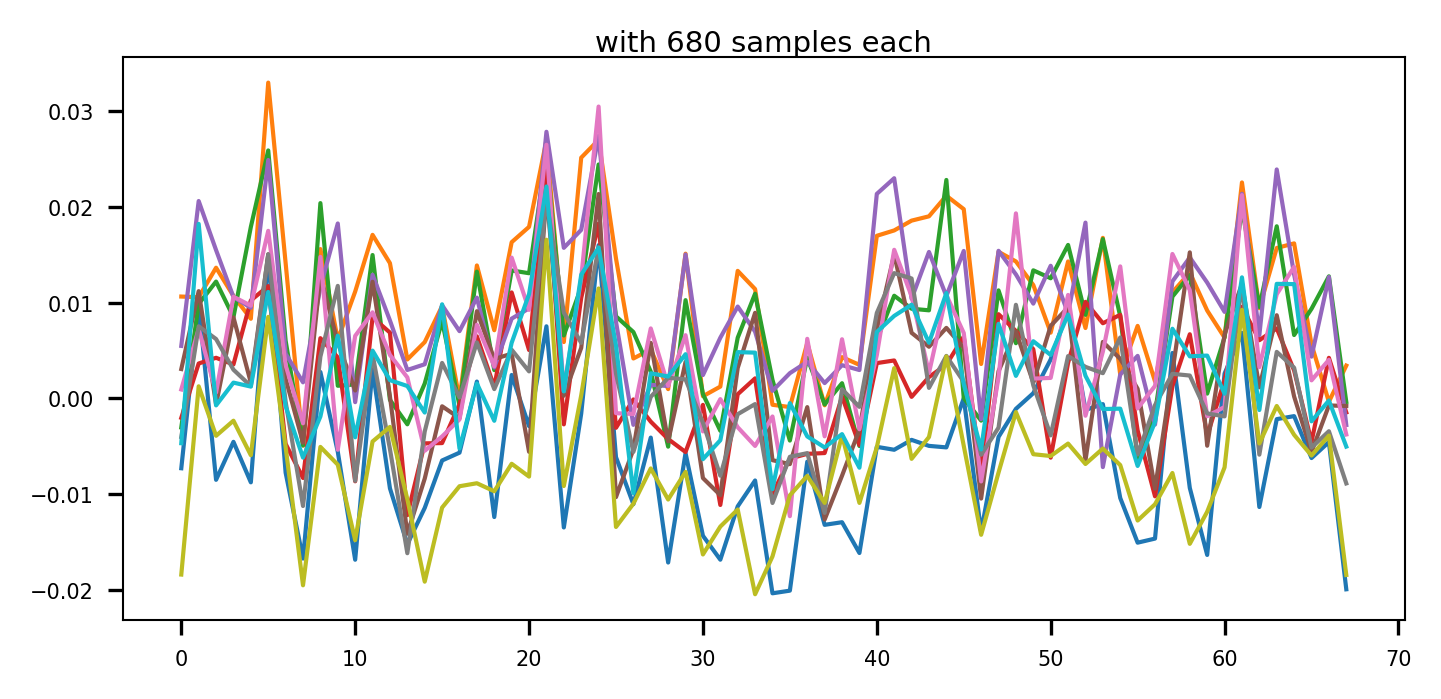

In [16]:
for res in posterior_knn_losses:
    plt.plot(res)
    plt.title(f'with {n_samples} samples each')

### PosteriorKNN

In [6]:
### If I ask question in index, the row will be the posterior probability of all questions
pseudo_answers = pd.DataFrame([user]*len(open_answers.index))
pseudo_answers.index = open_answers.index
pseudo_answers.loc[:,open_answers.index] = P_Yn1_Yin1.T
pseudo_answers

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.000000,0.836383,0.623620,0.052832,0.178127,0.654458,0.037993,0.867189,0.093628,0.023178,...,0.034329,0.220723,0.007171,0.855851,0.757216,0.363014,0.007750,1.0,0.0,0.331785
1,0.866916,1.000000,0.656957,0.044636,0.154621,0.704230,0.035615,0.857512,0.078146,0.017638,...,0.032029,0.194488,0.005998,0.877499,0.778606,0.346728,0.007922,1.0,0.0,0.353720
2,0.870901,0.885144,1.000000,0.038756,0.121431,0.789708,0.036324,0.834851,0.066295,0.014600,...,0.033762,0.159138,0.005680,0.900632,0.811941,0.323808,0.009147,1.0,0.0,0.399498
3,0.765946,0.624326,0.402339,1.000000,0.358872,0.353802,0.142376,0.779623,0.342493,0.124989,...,0.162767,0.464832,0.039350,0.601649,0.598958,0.560748,0.033695,1.0,0.0,0.254754
4,0.820318,0.686986,0.400435,0.113997,1.000000,0.329261,0.064816,0.897012,0.207250,0.062966,...,0.062736,0.402277,0.016850,0.703642,0.613013,0.489620,0.010653,1.0,0.0,0.198149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.868657,0.859260,0.654558,0.042121,0.155078,0.700095,0.033015,0.862358,0.073812,0.015791,...,0.028738,0.193594,0.005317,1.000000,0.777734,0.345151,0.007148,1.0,0.0,0.349836
69,0.865059,0.858166,0.664203,0.047198,0.152070,0.715085,0.038518,0.849811,0.082468,0.019585,...,0.035644,0.193407,0.006732,0.875402,1.000000,0.347043,0.008809,1.0,0.0,0.362864
70,0.831284,0.766024,0.530964,0.088572,0.243463,0.530016,0.062203,0.847462,0.158396,0.045059,...,0.061365,0.306057,0.013721,0.778727,0.695637,1.000000,0.012997,1.0,0.0,0.289020
71,0.731119,0.721024,0.617953,0.219270,0.218232,0.695819,0.266419,0.452600,0.364665,0.147404,...,0.358209,0.344435,0.068140,0.664450,0.727418,0.535440,1.000000,1.0,0.0,0.481425


In [7]:
RNG = np.random.default_rng(seed=0)

class TestNearestCandidates(NearestCandidates):
    def probabilistic(self, pseudo_answers: pd.DataFrame, n_samples=10):
        tree = self.cacheTree(pseudo_answers.columns)
        means = pseudo_answers.apply(self.recommend, axis=1)
        sample_means = pd.concat([means]*n_samples)
        samples = pd.concat([pseudo_answers]*n_samples)
        samples.iloc[:,:] = RNG.binomial(1, samples.values)
        sample_stds = samples.apply(self.recommend, axis=1)
        stds = pd.concat([sample_means,sample_stds], axis=1).apply(lambda row: overlap(row.iloc[0], row.iloc[1]), axis=1).groupby(level=0).mean()
        result = pd.concat([means, stds], axis=1)
        result.columns = ['recommendation', 'variance']
        return result

candidates = TestNearestCandidates(train_set=train_reactions)



In [61]:
### CHECK
idx = 2
sample_series = pseudo_answers.iloc[idx] ## Index by integer to get pd.Series
sample_df    = pseudo_answers.iloc[[idx]] ## Index by slice to keep pd.DataFrame
indices1 = candidates.recommend(sample_series)
indices2 = candidates.probabilistic(sample_df).iloc[0,0]
np.allclose(indices1, indices2)

True

In [62]:
%%time 
n_samples = user.isna().sum()*2
predictions = ideal.predict_user(user)
indices = candidates.recommend(predictions)
prior = candidates.probabilistic(pd.DataFrame(predictions).T, n_samples=n_samples)
print(np.allclose(indices, prior.iloc[0,0]), prior.iloc[0,1], n_samples)

True 0.375 136
CPU times: user 116 ms, sys: 141 ms, total: 256 ms
Wall time: 191 ms


In [73]:
%%time
n_samples = len(open_answers.index)*2
result = candidates.probabilistic(pseudo_answers, n_samples=n_samples)
result

CPU times: user 6.07 s, sys: 8.16 s, total: 14.2 s
Wall time: 9.21 s


,recommendation,variance
0,"[476, 893, 618, 646, 1610, 504, 821, 1162, 521...",0.452941
1,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.422794
2,"[476, 893, 618, 1610, 1162, 504, 821, 1559, 18...",0.431618
3,"[893, 646, 318, 157, 1098, 643, 521, 476, 433,...",0.197794
4,"[893, 318, 476, 646, 127, 1817, 683, 871, 618,...",0.331618
...,...,...
68,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.413235
69,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.402206
70,"[893, 476, 646, 433, 618, 1162, 1610, 521, 643...",0.297059
71,"[1706, 568, 897, 770, 711, 1036, 496, 1483, 24...",0.220588


### Complexity Old Version

In [59]:
%%time
n_samples = 136
means = pseudo_answers.apply(candidates.recommend, axis=1)
means.shape

CPU times: user 67.4 ms, sys: 95 ms, total: 162 ms
Wall time: 121 ms


(68,)

In [60]:
%%time 
sample_means = pd.concat([means]*n_samples)
samples = pd.concat([pseudo_answers]*n_samples)
samples.iloc[:,:] = RNG.binomial(1, samples.values)
samples.shape

CPU times: user 40.4 ms, sys: 4.31 ms, total: 44.7 ms
Wall time: 43.9 ms


(9248, 75)

In [61]:
%%time
sample_stds = samples.apply(candidates.recommend, axis=1)
sample_stds.shape

CPU times: user 6.09 s, sys: 8.47 s, total: 14.6 s
Wall time: 9.42 s


(9248,)

In [62]:
%%time 
stds = pd.concat([sample_means,sample_stds], axis=1).apply(lambda row: overlap(row.iloc[0], row.iloc[1]), axis=1).groupby(level=0).mean()
result = pd.concat([means, stds], axis=1)
result.columns = ['recommendation', 'variance']
result

CPU times: user 80.4 ms, sys: 1.03 ms, total: 81.5 ms
Wall time: 81 ms


,recommendation,variance
0,"[476, 893, 618, 646, 1610, 504, 821, 1162, 521...",0.391176
1,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.404412
2,"[476, 893, 618, 1610, 1162, 504, 821, 1559, 18...",0.403676
3,"[893, 646, 318, 157, 1098, 643, 521, 476, 433,...",0.206618
4,"[893, 318, 476, 646, 127, 1817, 683, 871, 618,...",0.349265
...,...,...
68,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.406618
69,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.436765
70,"[893, 476, 646, 433, 618, 1162, 1610, 521, 643...",0.302941
71,"[1706, 568, 897, 770, 711, 1036, 496, 1483, 24...",0.219853


### Complexity New Version

In [63]:
%%time
n_samples = 136
tree = candidates.cacheTree(pseudo_answers.columns)
_, numpy_means = tree.kneighbors(pseudo_answers.values)
numpy_means.shape

CPU times: user 2.24 ms, sys: 2.01 ms, total: 4.26 ms
Wall time: 1.96 ms


(68, 10)

In [64]:
%%time 
probabilities = np.vstack([pseudo_answers]*n_samples)
samples = RNG.binomial(1, probabilities)
samples.shape

CPU times: user 24.2 ms, sys: 1.6 ms, total: 25.8 ms
Wall time: 25.5 ms


(9248, 75)

In [65]:
%%time
sample_means = np.vstack([numpy_means]*n_samples)
_, sample_stds = tree.kneighbors(samples)
sample_stds.shape

CPU times: user 305 ms, sys: 43.9 ms, total: 349 ms
Wall time: 202 ms


(9248, 10)

In [66]:
%%time 
index = np.hstack([pseudo_answers.index]*n_samples)
stds = pd.DataFrame(np.hstack([sample_means,sample_stds]), index=index).apply(lambda row: overlap(row.iloc[:candidates.k], row.iloc[candidates.k:]), axis=1).groupby(level=0).mean()
means = pd.DataFrame(numpy_means, index=pseudo_answers.index).apply(lambda row: row.tolist(), axis=1)
result2 = pd.concat([means, stds], axis=1)
result2.columns = ['recommendation', 'variance']
result2

CPU times: user 177 ms, sys: 1.36 ms, total: 178 ms
Wall time: 178 ms


,recommendation,variance
0,"[393, 753, 519, 544, 1360, 418, 690, 990, 431,...",0.405882
1,"[393, 753, 519, 544, 1360, 990, 418, 690, 1037...",0.402941
2,"[393, 753, 519, 1360, 990, 418, 690, 1319, 159...",0.430147
3,"[753, 544, 256, 126, 932, 542, 431, 393, 354, ...",0.197059
4,"[753, 256, 393, 544, 99, 1538, 576, 734, 519, ...",0.340441
...,...,...
68,"[393, 753, 519, 544, 1360, 990, 418, 690, 1037...",0.397794
69,"[393, 753, 519, 544, 1360, 990, 418, 690, 1037...",0.413971
70,"[753, 393, 544, 354, 519, 990, 1360, 431, 542,...",0.295588
71,"[1442, 473, 756, 647, 598, 880, 413, 1257, 192...",0.191912


In [67]:
result

,recommendation,variance
0,"[476, 893, 618, 646, 1610, 504, 821, 1162, 521...",0.391176
1,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.404412
2,"[476, 893, 618, 1610, 1162, 504, 821, 1559, 18...",0.403676
3,"[893, 646, 318, 157, 1098, 643, 521, 476, 433,...",0.206618
4,"[893, 318, 476, 646, 127, 1817, 683, 871, 618,...",0.349265
...,...,...
68,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.406618
69,"[476, 893, 618, 646, 1610, 1162, 504, 821, 121...",0.436765
70,"[893, 476, 646, 433, 618, 1162, 1610, 521, 643...",0.302941
71,"[1706, 568, 897, 770, 711, 1036, 496, 1483, 24...",0.219853
